# Homework 2

# Task 1

**Implement a Decision Tree Classifier for your classification problem. You
may use a built-in package to implement your classifier.**

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("heart.csv")

# create features vectors, drop true values col
X = df.drop(columns=["target"])

# create true labels vector
y = df["target"]

"""
without stratification here, random sampling could make a skewed training distribution and learn biased splits
or create a test set with too many 1s/0s leading to misleading evaluation metrics.
Instead we preserve og class distribution so that we train the model on the true population distribution:
"""
# create stratified train/test split so class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # dataset is relatively small, so we are using the 80/20 train/test split
)

# fit baseline decision tree
baseline_tree = DecisionTreeClassifier(random_state=42) # create empty decision tree model object
baseline_tree.fit(X_train, y_train) # train the model to create the learned tree structure

# evaluate
preds = baseline_tree.predict(X_test) # store baseline model's predicted class labels for each sample in X_test
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds)) # get evaluation metrics for the baseline model

Accuracy: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



**Visualize the decision tree structure for at least three different parameter settings.
Comment on how the depth and complexity change the tree**

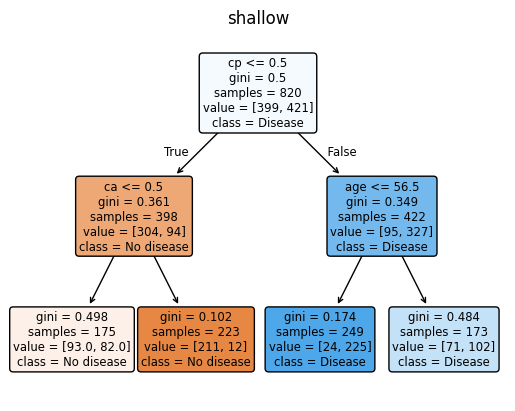

shallow test accuracy: 0.722


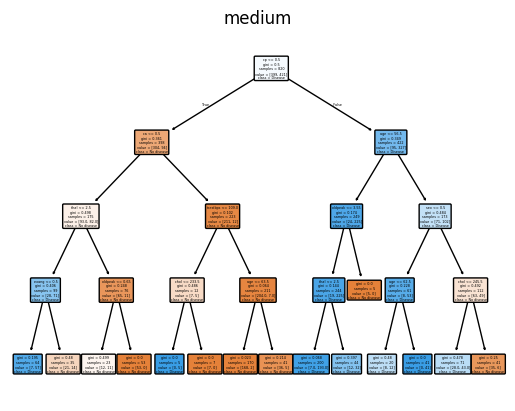

medium test accuracy: 0.839


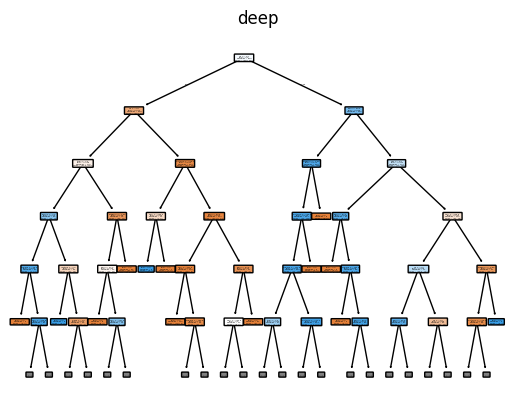

deep test accuracy: 0.9854


In [19]:
from sklearn.tree import plot_tree

"""
We will experiment with three different max_depth settings as it has the greatest influence
on complexity, controlling how many times the tree can split vertically, number of nodes, and number of leaves.
We choose a max_depth of 2 for the first setting because it creates a very simple tree with 4 leaf nodes, intended
to model an underfit tree. We choose max_depth of 4 for the medium setting because it creates a balanced, moderately
complex tree. Finally, we use max_depth = None for the last setting to model an overfit tree, as it will grow
until leaves are pure or no more splits are possible and thus approach near-memorization. We also use the parameter
min_samples_leaf for the medium setting so that no split can create a leaf with less than 5 samples and we prevent overfitting.
We introduce this parameter only for the second setting because this is the first time the risk of overfitting
appears and we want to keep this tree practical-- for the third tree, we intentionally want to see this extreme.
"""

# list of dictionaries that stores the three settings we will use to visualize the tree
settings = [
    {"name": "shallow", "params": dict(max_depth=2)},
    {"name": "medium", "params": dict(max_depth=4, min_samples_leaf=5)},
    {"name": "deep", "params": dict(max_depth=None)}
]

# create a new tree for each setting
for s in settings:
  experiment_tree = DecisionTreeClassifier(random_state=42, **s["params"]) # unpack dictionary to handle additional args when creating each tree
  experiment_tree.fit(X_train, y_train) # train each tree
  plt.figure()
  # draw the tree
  plot_tree(
      experiment_tree,
      feature_names=X.columns,
      class_names=["No disease", "Disease"], # map 0 --> No disease and 1 --> disease
      filled=True, # color-code nodes for class 0 and class 1
      rounded=True,
      max_depth = 5 # show at most 5 levels so it fits well on screen
  )
  plt.title(s["name"])
  plt.show()
  test_acc = accuracy_score(y_test, experiment_tree.predict(X_test))
  print(s["name"], "test accuracy:", round(test_acc, 4))


**Interpretation**
- as max_depth increases, the tree gains more nodes/leaves and goes from a simple, high-bias model to a highly complex, high-variance one.
- The shallow tree relies only on the strongest relationships and has large, impure leaves, indicating underfitting and inability to capture nuanced medical patterns.
- The medium tree displays more features and reasonable leaf sizes due to min_samples_leaf = 5. It represents a more balanced bias-variance trade-off, producing more detailed decision boundaries that can stil generalize across patient groups.
- The deep tree represents severe overfitting. It keeps splitting until almost every subgroup is pure with many leaves containing only a few samples, effectively memorizing the training data and learning overspecific rules that are unlikely to generalize.

**Do some research on what sensitivity analysis is and how it is performed (include
citations)**

Sensitivity analysis examines how variation in input features affects a model's predictions, helping to identify which variables the model relies on most and how stable those relationships are. Two common approaches are:  
1. One-At-A-Time (OAT): a local method in which a single feature is modified while the other features are fixed at a baseline value. This provides a clear insight into the model's local decision behavior and how dramatically individual input features affect its output.  
2. Variance-Based Decomposition: a global method which decomposes the total variance of model outputs into contributions from each input to quantify how much uncertainty in predications may be attributd to each feature.
  
  Sources:
  - https://pmc.ncbi.nlm.nih.gov/articles/PMC7885570/
  - https://www.sciencedirect.com/science/article/pii/S0019850122002590

**Perform a sensitivity analysis to measure the impact of at least two input
features on your model's decision boundary**

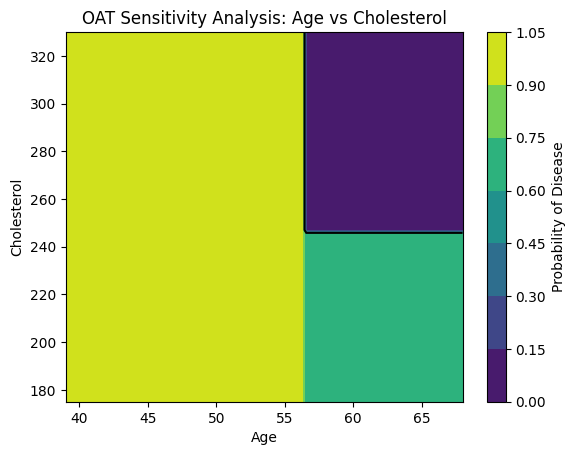

In [20]:
"""
method: one-at-a-time
features we modify: age and chol (patient age and cholesterol level)

process:
- use the medium-depth decision tree
- fix all features at their median values
- create a grid of possible age and chol values so we can observe output changes over gradual input changes
- predict the probability of disease for each grid point so we can observe output changes gradually over/in relation to input changes
- use 0.5 as the probability boundary for whether a patient has disease or not
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# train the medium-depth tree
experiment_tree = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=5)
experiment_tree.fit(X_train, y_train)

# set features to baseline value (medians)
baseline = X_train.median()

# create the grids for age and chol:
# use the 5th and 95th quartile to create a range between min and max vals while avoiding extreme outliers; more central population
# chose 100 points per axis between this range
age_vals = np.linspace(X_train["age"].quantile(0.05), X_train["age"].quantile(0.95), 100) # each age and cholesterol grid will have 10,000 grid points
chol_vals = np.linspace(X_train["chol"].quantile(0.05), X_train["chol"].quantile(0.95), 100)
# use a meshgrid to create all possible combinations of age, cholesterol values: https://numpy.org/devdocs/reference/generated/numpy.meshgrid.html
a, c = np.meshgrid(age_vals, chol_vals)
# build synthetic data where only age and chol values change and other feature vals stay the same:
# copy the row of baseline values a.size (10,000) times to build a synthetic dataset of 10,000 data points
synth_data = pd.DataFrame(np.tile(baseline.values, (a.size, 1)), columns = X_train.columns)
# change only age and chol
synth_data["age"] = a.ravel() # turns the age grid into one column that overwrites the age column of the synthetic dataset
synth_data["chol"] = c.ravel() # ^
# predict the probabilities of each class (0/no disease and 1/disease) for each of the 10,000 synthetic patients
probs = experiment_tree.predict_proba(synth_data)[:,1] # grab just the prob of class 1/disease
probs = probs.reshape(a.shape) # reshape the 1D list of 10,000 probs into a 2D grid so we can plot

# use a contour map to smoothly plot the relationship between predictions and changes in age and chol
plt.figure()
cs = plt.contourf(a, c, probs)
plt.colorbar(cs, label="Probability of Disease")
# set decision boundary to probability of 0.5
plt.contour(a, c, probs, levels=[0.5], colors="black")
plt.xlabel("Age")
plt.ylabel("Cholesterol")
plt.title("OAT Sensitivity Analysis: Age vs Cholesterol")
plt.show()


**Interpretation:** According to the tree, age is the dominant feature over cholesterol in influencing the predicted probability of heart disease for a patient. In this OAT plot, if you pick a point at age=50 and cholesterol=320 and move only vertically, the risk does not change; however, if you move only horizontally, such as by going to age=65 and cholesterol=320, the risk drops to near zero. This along with the near vertical boundary at around age 57 shows the model is far more sensitive to changes in age than changes in cholesterol, as varying cholesterol alone has limited influence on the model's output.

# Task 2

**Pick any one algorithm from each of the Bagging and Boosting ensemble methods. Implement both the algorithms using the same data.**

In [21]:
from sklearn.base import estimator_html_repr
# Bagging: BaggingClassifier
# Boosting: AdaBoost
# using decision trees as base learners

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# Bagging (Decision Tree a base learner)
# choosing 200 estimators so ensemble has enough learners to make stable predictions without making training unnecessarily slow
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=200, random_state=42)

# Boosting (AdaBoost)
# use max_depth = 1 becuase adaboost is designed to combine many weak leaners to gradually strengthen the model
# chose learning rate 0.5 to avoid overfitting to noise (too high) and learning very slowly (too low) and so each weak learner has moderate influence
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=200, learning_rate=0.5, random_state=42)

models = { "Bagging": bagging, "Boosting": adaboost }


I chose BaggingClassifier and AdaBoost as they are representative algorithms for Bagging and Boosting and fit naturally with the decision-tree work of this assignment.

**Use stratified k-fold cross-validation with at least three different folds (e.g., 5, 10, 15)**

In [22]:
# cross-validation
folds = [5, 10, 15]
for k in folds:
  print("Stratified K-Fold with k =", k)
  cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
  # bagging:
  bag_scores = cross_validate(bagging, X, y, cv=cv, scoring = ["accuracy", "precision", "f1"])
  print("\nBagging Results:")
  print("Accuracy:", bag_scores["test_accuracy"].mean())
  print("Precision:", bag_scores["test_precision"].mean())
  print("F1-score:", bag_scores["test_f1"].mean())
  # adaboost:
  ada_scores = cross_validate(adaboost, X, y, cv=cv, scoring = ["accuracy", "precision", "f1"])
  print("\nAdaBoost Results:")
  print("Accuracy:", ada_scores["test_accuracy"].mean())
  print("Precision:", ada_scores["test_precision"].mean())
  print("F1-score:", ada_scores["test_f1"].mean())

Stratified K-Fold with k = 5

Bagging Results:
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0

AdaBoost Results:
Accuracy: 0.8790243902439026
Precision: 0.868324249909317
F1-score: 0.8846204923000883
Stratified K-Fold with k = 10

Bagging Results:
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0

AdaBoost Results:
Accuracy: 0.8799067199695413
Precision: 0.8664057888190572
F1-score: 0.8861997760320313
Stratified K-Fold with k = 15

Bagging Results:
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0

AdaBoost Results:
Accuracy: 0.8770247229326513
Precision: 0.8654458012345143
F1-score: 0.8824988546858177


**Analysis:**  
- Bagging is the superior model, achieving perfect accuracy, precision, and F1-score across all folds. This is likely due to how Bagging averages the predictions of its ensemble, which reduces variance aggressively and can lead to memorization for small or highly structured datasets such as this one.
- AdaBoost's performance follows closely. While its performance is still high, it has greater error than Bagging.

**Comment on the behavior of each algorithm under the metrics. Does the performance
ranking change based on the metric used? Why?**
  
  BaggingClassifier achieved perfect performance across all folds with accuracy, precision, and F1 each scoring 1.0. This means that, when predictions from many trees were averaged together, the ensemble made no errors in cross-validation-- averaging the individual trees removes variance and produces very stable predictions.
    
  AdaBoost also performed well, but with a lower score of around 0.88 for all metrics. Rather than averaging many deep trees, AdaBoost builds a sequence of very simple learners and repeatedly focuses on the cases it previously got wrong. This approach is less likely to lead to memorization of the data, which is why its performance is strong but imperfect.

  The performance ranking does not change based on the metric used, as bagging outperformed adaboost across all metrics for all folds. This occurs because bagging averages many deep decision trees, which dramatically reduces variance and can lead to near-memorization. AdaBoost continuously emphasizes misclassified samples and uses weak learners, making it less prone to overfitting but also less likely to reach perfect scores.

# Task 3

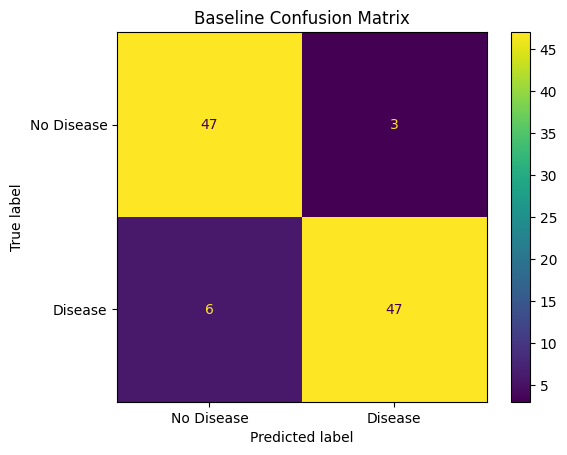

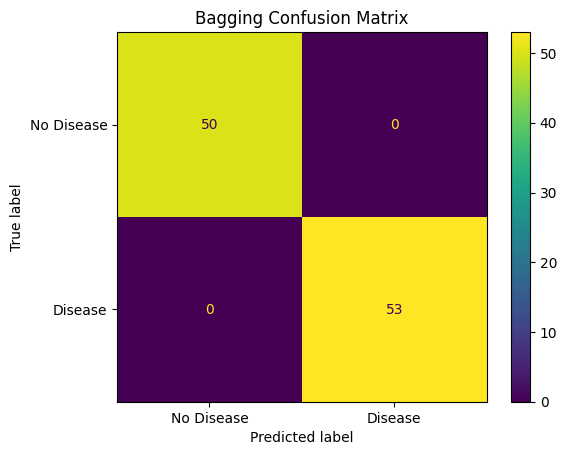

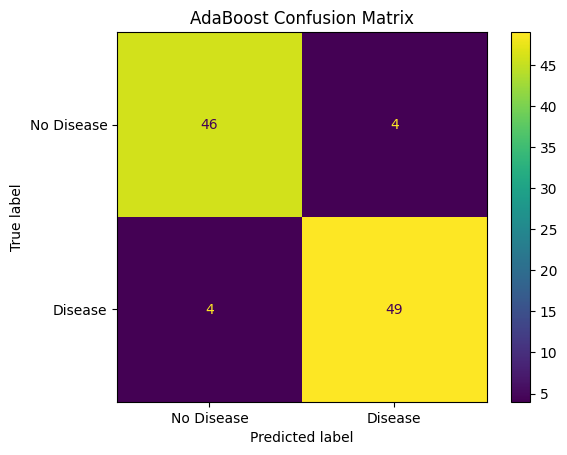

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# three models: baseline tree, bagging, adaboost
# create  baseline tree
tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 5, random_state  = 42)
# create bagging ensemble with 200 trees
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=200, random_state=42)
# create adaboost ensemble with 200 weak learners
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=200, learning_rate=0.5, random_state=42)

# dictionary so we can loop through the models
models = { "Baseline": tree, "Bagging": bagging, "AdaBoost": adaboost }

# take one fold
# divide the dataset into 10 folds of proportionate class distributions
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# grab the first fold's train and test indices (position of first pair of (train, test))
# this is our selected fold
train_idx, test_idx = next(cv.split(X,y))

# select the training rows and test columns from X using the indices
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx] # dataframe of training examples
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # dataframe of test examples

# loop over each model
for name, model in models.items():
  # train the current model on the fold's training data
  model.fit(X_train, y_train)
  # use the trained model to predict labels for the test set
  preds = model.predict(X_test)
  # build the confusion matrix
  cm = confusion_matrix(y_test, preds)
  # create display object to plot the confusion matrix
  disp = ConfusionMatrixDisplay(cm, display_labels=["No Disease", "Disease"])
  disp.plot()
  plt.title(name + " Confusion Matrix") # Concatenate strings for title
  plt.show()

**confusion matrix analysis:**  

Baseline:
- 47 true negatives, 3 false positives
- 47 true positives, 6 false negatives  
- worst performance: sensitive to the specific training sample, rougher decision boundaries that produce uneven errors

Bagging:
- 50 true negatives, 0 false positives
- 53 true positives, 0 false negatives  
- best performance: averaging the 200 trees removes instability so well it produces near-memorization

AdaBoost:
- 46 true negatives, 4 false positives
- 49 true positives, 4 false negatives
- 2nd best performance: errors are balanced. Focus on difficult cases improves the single tree, but weak-learner composition blocks it from perfection



**Statistical test: paired t-test**

In [24]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
import numpy as np

# create object to divide dataset into 10 balanced folds for cross-validation
# for statistical test we need a performance score from each fold, for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run 10-fold cross-validation and return an array of F1 scores per fold (10 F1 scores per model)
f1_base = cross_val_score(tree, X, y, cv=cv, scoring="f1")
f1_bag = cross_val_score(bagging, X, y, cv=cv, scoring="f1")
f1_ada = cross_val_score(adaboost, X, y, cv=cv, scoring="f1")

# perform t-tests: store the t statistic (as t) and the probability/p-value that the observed difference could happen by random chance (as p)
# bagging vs adaboost
t1, p1 = ttest_rel(f1_bag, f1_ada)
# bagging vs tree
t2, p2 = ttest_rel(f1_bag, f1_base)
# adaboost vs tree
t3, p3 = ttest_rel(f1_ada, f1_base)

print("Bagging vs AdaBoost p-value:", p1)
print("Bagging vs Baseline p-value:", p2)
print("Adaboost vs Baseline:", p3)

Bagging vs AdaBoost p-value: 4.065133518549843e-06
Bagging vs Baseline p-value: 2.8555550498466947e-06
Adaboost vs Baseline: 0.06464374231601071


Analysis:  
- bagging vs adaboost: extremely small p value, the difference is statistically significant and not due to random fold variation
- bagging vs baseline: extremely small p value, bagging is significantly better than a single decision tree and difference is not random
- adaboost vs baseline: p > 0.05. We cannot claim adaboost is significantly better than the baseline tree
- conclusion: bagging significantly outperforms both methods, and adaboost and baseline are statistically similalr with no meaningful improvement over the other

**Discussion of tradeoffs**  
The baseline, single decision tree can closely fit the training data and keep bias low, but depends heavily on its training set. This means the model is unstable and small changes in the dataset can significantly impact results, which produces high variance-- the baseline model has low bias but high variance.  

The Bagging model expresses the low bias of the decision trees while greatly reducing variance. They train hundreds of trees on different bootstrapped samples and average their predictions, canceling out occasional mistakes to form a highly stable model. Thus, Bagging maintains low bias while dramatically reducing variance, but risks approaching memorization if the dataset is small or highly structured, such as in this case.  

The Adaboost middle finds a middle ground between the baseline and Bagging. It utilizes sequential boosting to reduce the bias of its simple leaners and gradually strengthen the model. However, this approach prevents variance from being reduced as drastically as Bagging and it remains more sensitive to noise.